# Content-Based Image Retrieval
Recherche d’images par le contenu à partir des caractéristiques:
d’histogrammes couleurs et formes (Moments de Hu)

## Librairies nécessaires

In [26]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## Source des images

In [4]:
# Liste des images 
IMAGES = glob.glob('coil-100/obj*.png')
#IMAGES = glob.glob('coil-100/obj*.png')

print("Nombre Total d'images dans la base de données: {nb} ". format(nb = len(IMAGES)))

Nombre Total d'images dans la base de données: 7200 


In [5]:
# Image requete Exemple
image_requete = 'coil-100/obj1__120.png'
img_bgr = cv2.imread(image_requete)
# Convertir de BGR en RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

## Calculer les histogrammes de toutes les images de la base

--> calculer l'histogramme à 3 couleurs x 32 de chaque image.
Ensuite nous l'enregistrons dans un dictionnaire dont la clé est l'image et la valeur l'histogramme calculé

In [6]:
def imagesHistogram(data):
    '''
    Fonction pour calculer l'histogramme de toutes les images de la base
    input: liste des images
    ouput: histogram normalisé pour chaque image.
    '''
    
    # Dictionnaire pour stocker les images et leur histogramme correspondant
    HISTOGRAMMES = {}
    
    i = 1

    for idx, elt in enumerate(data):
        # Lire les images par défaut dans l'espace BGR-> Bleu, Green, Red
        img_bgr = cv2.imread(elt)

        # Convertir de BGR en RGB
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Calcul de l'histogramme sur les 3 canaux
        hist_img = cv2.calcHist([img_rgb], [0, 1, 2], None, [32, 32, 32],
                            [0, 256, 0, 256, 0, 256])
        
        # Normaliser histogramme
        hist_normalise = cv2.normalize(hist_img, hist_img).flatten()
        
        if hist_normalise is not None:
            
            # Ajouter à la liste des histogrammes
            HISTOGRAMMES[elt] = hist_normalise
            #print("Image {i}:  {g} Traitée avec succès".format(i=i, g=elt))
            i+=1
    return HISTOGRAMMES
            
HISTOGRAMMES = imagesHistogram(IMAGES)

In [7]:
# Taille dictionnaire contenant les histogrammes 7200 = nombre d'images base de données
print("Taille dictionnaire contenant les histogrammes:", len(HISTOGRAMMES))

Taille dictionnaire contenant les histogrammes: 7200


## Descripteurs de forme: Les moments de Hu

--> Calculer les moments et le vecteur de caractéristiques(7 caracteristiques) de chaque image.

--> Enregistrer le vecteur dans le dictionnaire HUMOMENTS. La clé est l'image et la valeur le vecteur de 7 caracteristiques.

In [8]:
def descripteursHuMoment(data):
    '''
    Fonction pour calculer les moments de hu de toutes les images de la base.
    input: liste des images de la base
    ouput: vecteur de caracteristique pour chaque image.
    '''
    
    # Dictionnaire pour stocker les images et leur caractéristiques de Hu.
    HUMOMENTS = {}
    i = 1
    for idx, elt in enumerate(data):
        
        # Lire les images par défaut dans l'espace BGR-> Bleu, Green, Red
        img_bgr = cv2.imread(elt)

        # Convertir de BGR en Gray
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        
        # Lisser l'image pour reduire les bruits: filtre 
        img_gray = cv2.blur(img_gray, (3,3))

        # Transformer l'image en image binaire car les images sont sur fond noir.
        # Methode Seuillage simple : Si le pixel < 128 , alors pixel = 0, sinon pixel = 255.
        _,img_bin = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)

        # Calculer les moments
        img_moments = cv2.moments(img_bin)

        # Calculer les Hu Moments
        img_huMoments = cv2.HuMoments(img_moments)
    
        '''# Mise à l'echelle
        for i in range(0, 7):
            img_huMoments[i] = -1 * math.copysign(1.0, img_huMoments[i]) * math.log10(abs(img_huMoments[i]))
        print(img_huMoments)
        '''
        
        if img_huMoments is not None:
            
            # Ajouter au dictionnaire des moments. cle = image, valeur = vecteur hu moment
            HUMOMENTS[elt] = img_huMoments
            #print(img_huMoments)
            #print(' ')
            #print("-> Image {i}:  {g} Traitée avec succès".format(i=i, g=elt))
            #print(' ')

            
            i+=1
    return HUMOMENTS
            
HUMOMENTS = descripteursHuMoment(IMAGES)

In [9]:
# Taille dictionnaire contenant les vecteurs Hu 7200 = nombre d'images base de données
print("Taille dictionnaire des vecteurs de caracteristiques des hu moments:", len(HUMOMENTS))

Taille dictionnaire des vecteurs de caracteristiques des hu moments: 7200


## Calculer l'histogramme et le vecteur hu moment de l'image à chercher

In [10]:
def histHuImageRequete(data):
    '''
    Fonction pour calculer l'histogramme des images
    input: liste des images
    ouput: histogram normalisé
    '''
    # Lire les images par defaut dans l'espace BGR-> Bleu, Green, Red
    img_bgr = cv2.imread(data)

    # Convertir de BGR en RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Calculer de l'histogramme sur les 3 canaux
    hist_img = cv2.calcHist([img_rgb], [0, 1, 2], None, [32, 32, 32],
                            [0, 256, 0, 256, 0, 256])
    hist_normalise = cv2.normalize(hist_img, hist_img).flatten()
    
    # Calculer les Hu moments 
    # Convertir de BGR en Gray
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Seuillage
    _,img_bin = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)

    # Calculer les moments
    img_moments = cv2.moments(img_bin)

    # Calculate Hu Moments
    img_huMoments = cv2.HuMoments(img_moments)

    return hist_normalise, img_huMoments

hist_requete, hu_requete = histHuImageRequete(image_requete)

## Intersection des histogrammes
-> Comparer l'histogramme de limage requete et celui de chaque image de la base de données. 

-> Renvoyer toutes les distances.

-> Intersection de 2 histogrammes. méthode du Chi-2.

In [11]:
def compareHis(hist1, hist2):
    '''
    Fonction pour comparer deux histogrammes.
    input: histogrammes de tous les images et histogramme de l'image query.
    output: distance entre l'histogramme de l'image query et toutes les images de la base de données
    '''
    
    # Dictionnaire pour stocker les distances entre les histogrammes des images de la base et l'image requete
    DISTANCES_HIST = {}
    
    for (cle, valeur) in hist1.items():
        distance = cv2.compareHist(hist2, valeur, cv2.HISTCMP_CHISQR)
        DISTANCES_HIST[cle] = distance
    return DISTANCES_HIST
        
DISTANCES_HIST = compareHis(HISTOGRAMMES, hist_requete)

In [12]:
# Taille dictionnaire contenant les distances entre les histogrammes. 7200 distances
print("Taille dictionnaire des distances entre les histogrammes:", len(DISTANCES_HIST))

Taille dictionnaire des distances entre les histogrammes: 7200


## Distance entre les moments Comparer les vecteurs de caracteristiques d hus
-> Calculer la distance euclidienne classique entre le vecteur de caracteristique de l'image requete et
    celui de chaque image de la base de données

-> Renvoyer toutes les distances.

In [13]:
def compareHu(hu1, hue2):
    '''
    Fonction pour comparer deux hu moments.
    input: histogrammes de tous les images de la base et histogramme de l'image à chercher.
    output: distance entre l'histogramme de l'image de test
    '''
    
    # Dictionnaire pour stocker les distances apres la comparaison
    DISTANCES_HU = {}
    
    for (cle, valeur) in hu1.items():
        # Calculer la distance ecludienne entre deux vecteurs
        dist = np.linalg.norm(valeur - hue2)
        
        # Ajouter a la liste
        DISTANCES_HU[cle] = dist
    return DISTANCES_HU

DISTANCES_HU = compareHu(HUMOMENTS, hu_requete)

In [14]:
# Taille dictionnaire contenant les distances entre les Hu moments. 7200 images = 7200 comparaisons
print("Taille dictionnaire des distances entre vecteurs Hu moments:", len(DISTANCES_HU))

Taille dictionnaire des distances entre vecteurs Hu moments: 7200


## similarité entre deux images en fonction deux distances
-> Attribuer un poids a chaque distance. Par defaut les poids sont egaux w1 = w2 = 0.5. Aucune Distance n'influence plus que l'autre

In [15]:
def similarite(DISTANCES_HIST, DISTANCES_HU):
    '''
    Fonction pour calculer le score de la simularité globale.
    input: Dictionnaire distances hu, et Dictionnaire distances histogramme 
    output: score
    '''
    
    # Dictionnaire pour stocker le score de la simularité
    SCORES = {}

    w_couleur = 0.5 # Poids distance couleur
    w_forme = 0.5 # Poids distance forme
    
    
    for (cle1, valeur1) in DISTANCES_HIST.items():
        for (cle2, valeur2) in DISTANCES_HU.items():
            if cle1 == cle2:
                score = ((w_couleur * valeur1) +(w_forme * valeur2))
                SCORES[cle1] = score
    return SCORES
                
SCORES = similarite(DISTANCES_HIST, DISTANCES_HU)

In [16]:
'''
print("Resultats calcul de simularité Image Requete: {}".format(os.path.splitext(image_requete.split("/")[1])[0]))
print("")
for i, j in SCORES.items():

    print("Score = {a} -> Similarité entre {b} et {c} ".format(a = j, 
                                                               b = os.path.splitext(image_requete.split("/")[1])[0],
                                                               c = os.path.splitext(i.split("/")[1])[0]))
'''

'\nprint("Resultats calcul de simularité Image Requete: {}".format(os.path.splitext(image_requete.split("/")[1])[0]))\nprint("")\nfor i, j in SCORES.items():\n\n    print("Score = {a} -> Similarité entre {b} et {c} ".format(a = j, \n                                                               b = os.path.splitext(image_requete.split("/")[1])[0],\n                                                               c = os.path.splitext(i.split("/")[1])[0]))\n'

## Resultats Top N des images les plus proches de l'image Requete: pour N = 5
-> Trier le dictionnaire par ordre decroissant de la valeur du score

In [17]:
# Recuperation du top N -> items() slicing 
N = 5
resultats = dict(list(sorted(SCORES.items(), key=lambda x: x[1]))[0: N])

In [18]:
#Liste des images pour afficher
t = []

print("Image Requete: {}".format(os.path.splitext(image_requete.split("/")[1])[0]))
print("")
print("Résultats:")
for i, j in resultats.items():
    print("{c} ....... distance = {a} ".format(a = j, c = os.path.splitext(i.split("/")[1])[0]))
    img = cv2.imread(i)
    # Convertir de BGR en RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    t.append(img)
    

Image Requete: obj1__120

Résultats:
obj1__120 ....... distance = 5.651223404867245e-06 
obj1__125 ....... distance = 0.1575443226446562 
obj1__130 ....... distance = 0.21116662044632747 
obj1__135 ....... distance = 0.261765302893642 
obj1__115 ....... distance = 0.28347602013762047 


## Test top 5 Visualisation

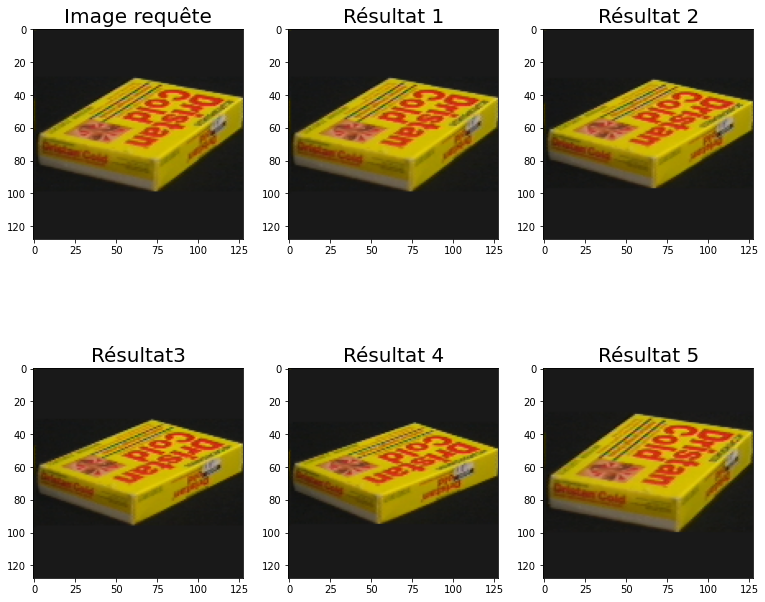

In [19]:
# Resultats
f, a = plt.subplots(2, 3, figsize=(10, 10))
f.tight_layout()

a[0][0].imshow(img_rgb)
a[0][0].set_title('Image requête', fontsize=20)

a[0][1].imshow(t[0])
a[0][1].set_title('Résultat 1', fontsize=20)


a[0][2].imshow(t[1])
a[0][2].set_title('Résultat 2', fontsize=20)

a[1][0].imshow(t[2])
a[1][0].set_title('Résultat3', fontsize=20)

a[1][1].imshow(t[3])
a[1][1].set_title('Résultat 4', fontsize=20)

a[1][2].imshow(t[4])
a[1][2].set_title('Résultat 5', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Rechercher une image
###  La recherche etant basée sur le contenu . Comme nous utilisons la meme base de données pour le test,   l'image requête sera toujours renvoyée en première position  dans le resultat de la recherche.

In [23]:
#HISTOGRAMMES = imagesHistogram(IMAGES)
#HUMOMENTS = descripteursHuMoment(IMAGES)

In [32]:
print("Rechercher une Image")
print("Exemple: obj95__215.png")
image = (str(input("Veuillez inserer le nom d'une image: ")))
N = (int(input("Nombre total d'images à renvoyer: ")))

# Contatener avec le nom de la base de données
source_image = "coil-100/"+ image


if source_image not in IMAGES:
    print("Images Inexistante. Saisissez un nom correct")
else:
    t1 = time.time()
    hist_requete, hu_requete = histHuImageRequete(source_image)
    DISTANCES_HIST = compareHis(HISTOGRAMMES, hist_requete)
    DISTANCES_HU = compareHu(HUMOMENTS, hu_requete)
    SCORES = similarite(DISTANCES_HIST, DISTANCES_HU)
    
    # Recuperation du top N -> items() slicing 
    resultats = dict(list(sorted(SCORES.items(), key=lambda x: x[1]))[0: N])
    print("")
    print("Image Requete: {}".format(os.path.splitext(source_image.split("/")[1])[0]))
    print("")
    print("Résultats:")
    k=1
    for i, j in resultats.items():
        print(" {k}-{c} ....... distance = {a} ".format(k=k, a = round(j, 3), c = os.path.splitext(i.split("/")[1])[0]))
        k+=1
    t2 = time.time()
    t = t2 -t1
    print("")
    print("La durée d'exccution est de {duree} s ".format(duree=round(t,1) ))

Rechercher une Image
Exemple: obj95__215.png
Veuillez inserer le nom d'une image: obj100__335.png
Nombre total d'images à renvoyer: 10

Image Requete: obj100__335

Résultats:
 1-obj100__335 ....... distance = 0.004 
 2-obj100__340 ....... distance = 0.151 
 3-obj100__330 ....... distance = 0.159 
 4-obj100__345 ....... distance = 0.225 
 5-obj100__325 ....... distance = 0.272 
 6-obj100__165 ....... distance = 0.318 
 7-obj100__350 ....... distance = 0.331 
 8-obj100__170 ....... distance = 0.334 
 9-obj100__160 ....... distance = 0.344 
 10-obj100__155 ....... distance = 0.413 

La durée d'exccution est de 3.2 s 
